In [ ]:
import pandas as pd
import numpy as np
import re
import keras
from tqdm import tqdm
import pickle as pkl
from tensorflow.keras import layers
import tensorflow as tf
import gc
from sklearn.metrics import accuracy_score
from gensim.models import Word2Vec
from scipy.spatial.distance import euclidean
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.decomposition import PCA
import multiprocessing
gc.enable()

import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold

import statsmodels.api as sm
import pylab as plt
from scipy import stats

%pylab inline

from google.colab import drive
drive.mount('/content/drive')

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Word2Vec для последовательностей товаров

###Считываем данные и подготавливаем выборку для обучения word2vec

In [ ]:
order_features = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Diplom/instacart-market-basket-analysis/test_train/order_features.csv')
order_features['prod_seq'] = order_features['prod_seq'].apply(lambda x: list(np.fromstring(x.strip('[ ]'), dtype=int, sep=', ')))
order_features['prev_seq'] = order_features['prev_seq'].apply(lambda x: list(np.fromstring(x.strip('[ ]'), dtype=int, sep=', ')))
order_features['prev_orders_seq'] = order_features['prev_orders_seq'].apply(lambda x: list(np.fromstring(x.strip('[ ]'), dtype=int, sep=', ')))

train_positive = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Diplom/instacart-market-basket-analysis/test_train/train_positive.csv')
train_negative = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Diplom/instacart-market-basket-analysis/test_train/train_negative.csv')

with open('/content/drive/My Drive/Colab Notebooks/Diplom/instacart-market-basket-analysis/test_train/id_to_token.pkl', 'rb') as f:
  id_to_token = pkl.load(f)

with open('/content/drive/My Drive/Colab Notebooks/Diplom/instacart-market-basket-analysis/test_train/token_to_id.pkl', 'rb') as f:
  token_to_id = pkl.load(f)

with open('/content/drive/My Drive/Colab Notebooks/Diplom/instacart-market-basket-analysis/test_train/val_orders.pkl', 'rb') as f:
  val_orders = pkl.load(f)

with open('/content/drive/My Drive/Colab Notebooks/Diplom/instacart-market-basket-analysis/test_train/test_orders.pkl', 'rb') as f:
  test_orders = pkl.load(f)

In [ ]:
df_train = order_features[(~order_features['order_id'].isin(val_orders)) & (~order_features['order_id'].isin(test_orders))].reset_index(drop=True)
df_val = order_features[order_features['order_id'].isin(val_orders)].reset_index(drop=True)
df_test = order_features[order_features['order_id'].isin(test_orders)].reset_index(drop=True)

In [ ]:
df_train['prod_seq'] = df_train['prod_seq'].apply(lambda x: list(map(lambda y: str(y), x)))

###Обучаем word2vec

In [ ]:
print(len(token_to_id)**0.25)

12.551386264918223


In [ ]:
mean = np.mean(list(map(len, df_train['prod_seq'])))
median = np.median(list(map(len, df_train['prod_seq'])))
maxlen = max(list(map(len, df_train['prod_seq'])))

print(mean)
print(median)
print(maxlen)

9.551242266330972
8.0
78


In [ ]:
wv_size = 100

w2v = Word2Vec(df_train['prod_seq'], size=wv_size, window=maxlen, min_count=1, workers=multiprocessing.cpu_count())

In [ ]:
w2v.train(df_train['prod_seq'], total_examples=df_train.shape[0], epochs=25)

(23199243, 24468850)

In [ ]:
#w2v.save('/content/drive/My Drive/Colab Notebooks/Diplom/models/word_to_vec/w2v_size100_eps25.model')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


# Word2Vec + XGB

###Понижаем размерность векторов word2vec

In [ ]:
pos_neg = pd.concat((train_positive, train_negative), axis=0)

In [ ]:
data_train = pos_neg[(~pos_neg['order_id'].isin(val_orders)) & (~pos_neg['order_id'].isin(test_orders))].sample(frac=1)
data_val = pos_neg[pos_neg['order_id'].isin(val_orders)].sample(frac=1)
data_test = pos_neg[pos_neg['order_id'].isin(test_orders)].sample(frac=1)

In [ ]:
w2v_matrix = np.zeros((len(id_to_token), 100))
for i_d, token in id_to_token.items():
  w2v_matrix[i_d, :] = w2v.wv[str(token)]

In [ ]:
pca = PCA(n_components=13, random_state=432)

w2v_matrix_red = pca.fit_transform(w2v_matrix)

In [ ]:
w2v_to_df = np.zeros((w2v_matrix_red.shape[0], w2v_matrix_red.shape[1] + 1))
for i_d, token in id_to_token.items():
  w2v_to_df[i_d, 0] = token
  w2v_to_df[i_d, 1:] = w2v_matrix_red[i_d, :]

In [ ]:
w2v_df = pd.DataFrame(w2v_to_df, columns=['product_id', '0', '1', '2', '3', '4', '5', '6', '7' ,'8', '9', '10', '11', '12'])

###Собираем новый датасет для бустинга

In [ ]:
new_data_train = data_train#.merge(w2v_df, how='inner', on='product_id')
new_data_val = data_val#.merge(w2v_df, how='inner', on='product_id')
new_data_test = data_test#.merge(w2v_df, how='inner', on='product_id')

In [ ]:
new_data_val.head()

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,times_lastN,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio,order_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,label
1141483,3956,12341,1,0.593333,1,5.0,0.169811,2098.0,0.765491,2519426,7,3,14,9.0,1
274160,2846,44661,5,1.000000,5,11.0,0.497268,417.0,0.604317,3005259,12,6,21,1.0,1
1187274,9571,43295,1,0.833333,1,2.0,0.058824,845.0,0.752663,2144152,4,6,18,22.0,1
1170401,7496,17948,1,0.900000,1,1.0,0.000000,1066.0,0.623827,2546250,3,3,22,18.0,1
1048595,10666,37524,5,0.131579,0,40.0,0.697411,391.0,0.585678,481570,42,0,13,7.0,1


In [ ]:
new_data_val = new_data_val.merge(order_features[['order_id', 'prev_orders_seq']], how='inner', on='order_id')
new_data_test = new_data_test.merge(order_features[['order_id', 'prev_orders_seq']], how='inner', on='order_id')

In [ ]:
new_data_train = new_data_train.sample(frac=1).reset_index(drop=True)

In [ ]:
new_train_set = new_data_train[new_data_train['label'] == 1]
new_val_set = new_data_val[new_data_val['label'] == 1]
new_test_set = new_data_test[new_data_test['label'] == 1]
it = 1

###Ищем оптимальные параметры для бустинга на валидации

In [ ]:
feat_cols = ['uxp_total_bought', 'uxp_reorder_ratio', 'times_lastN', 'u_total_orders', 'u_reordered_ratio', 'p_total_purchases',
             'p_reorder_ratio', 'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'label']

In [ ]:
params = [{'eval_metric':'logloss', 'min_child_weight':i, 'gamma':j, 'subsample':k, 'colsample_bytree':x, 'max_depth':y} for i in [1, 5] 
       for j in [0, 1] for k in [0.6, 0.75, 0.8] for x in [0.4, 0.6] for y in [3, 5]]

In [ ]:
best_params = params[0]
best_quality = 0

for param in tqdm(params, position=0):
  X_train, y_train = new_data_train[feat_cols[:-1]], new_data_train[feat_cols[-1]]

  xgbc = xgb.XGBClassifier(objective='binary:logistic', parameters=param, num_boost_round=10, n_jobs=-1, silent=False, )

  model_xgb = xgbc.fit(X_train, y_train)

  xgb.plot_importance(model_xgb)

  precision_xgb = {}
  recall_xgb = {}
  for i in range(1, 11):
    precision_xgb[i] = 0
    recall_xgb[i] = 0

  total = 0

  for user_id, group_u in new_val_set.groupby('user_id'):

    for order_id, group_o in group_u.groupby('order_id'):
      #Купленные товары
      bought = np.array(list(set(group_o['product_id'])))

      #Ищем товары, которые порекомендует бустинг
      order = group_o[['order_id', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']]
      prods = new_data_train[new_data_train['user_id']==user_id].drop_duplicates(subset=['product_id'])

      prods['order_dow'] = prods['order_dow'].apply(lambda x: order['order_dow'].values[0])
      prods['order_hour_of_day'] = prods['order_hour_of_day'].apply(lambda x: order['order_hour_of_day'].values[0])
      prods['days_since_prior_order'] = prods['days_since_prior_order'].apply(lambda x: order['days_since_prior_order'].values[0])

      prods['prob'] =  model_xgb.predict_proba(prods[feat_cols[:-1]])[:, 1]

      for i in range(1, 11):
        recommended_xgb = np.array(list(map(lambda x:int(x[0]),sorted(prods[['product_id', 'prob']].values, key=lambda x: x[1], reverse=True)[:i])))
        precision_xgb[i] += np.intersect1d(bought, recommended_xgb).shape[0]/recommended_xgb.shape[0]
        recall_xgb[i] += np.intersect1d(bought, recommended_xgb).shape[0]/bought.shape[0]

      total += 1

  for i in range(1, 11):
    precision_xgb[i] = precision_xgb[i]/total
    recall_xgb[i] = recall_xgb[i]/total

  quality_precision = []
  quality_recall = []

  for i in range(1, 11):
    quality_precision.append(precision_xgb[i])
    quality_recall.append(recall_xgb[i])
  new_quality = (np.mean(quality_precision) + np.mean(quality_recall))/2.

  if new_quality > best_quality:
    best_quality = new_quality
    best_params = param

print(best_params)

In [ ]:
best_params = {'colsample_bytree': 0.4,
 'eval_metric': 'logloss',
 'gamma': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'subsample': 0.6}

###Обучаем и проверяем качество на валидации

С признаками w2v

100%|██████████| 6605/6605 [06:57<00:00, 15.81it/s]




{1: 0.44496593489780467, 2: 0.38523845571536713, 3: 0.3435150138783797, 4: 0.3121940449154684, 5: 0.2897072924551998, 6: 0.2715569013373665, 7: 0.25796510580008947, 8: 0.24761174795429164, 9: 0.24069253691888784, 10: 0.2367342561551393}
{1: 0.08169110645449497, 2: 0.13066208578909083, 3: 0.16506721454593531, 4: 0.19177726272677742, 5: 0.21380720671364387, 6: 0.2317511149395426, 7: 0.24833056718052468, 8: 0.2650256397348837, 9: 0.2832790282215032, 10: 0.302956106235157}


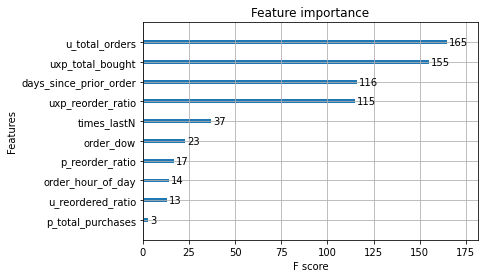

In [ ]:
feat_cols = ['uxp_total_bought', 'uxp_reorder_ratio', 'times_lastN', 'u_total_orders', 'u_reordered_ratio', 'p_total_purchases',
             'p_reorder_ratio', 'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'label']

X_train, y_train = new_data_train[feat_cols[:-1]], new_data_train[feat_cols[-1]]

parameters = best_params

xgbc = xgb.XGBClassifier(objective='binary:logistic', parameters=parameters, num_boost_round=10, n_jobs=-1, silent=False)

model_xgb = xgbc.fit(X_train, y_train)

xgb.plot_importance(model_xgb)


precision_xgb = {}
recall_xgb = {}
for i in range(1, 11):
  precision_xgb[i] = 0
  recall_xgb[i] = 0

total = 0

for user_id, group_u in tqdm(new_val_set.groupby('user_id'), position=0):

  for order_id, group_o in group_u.groupby('order_id'):
    #Купленные товары
    bought = np.array(list(set(group_o['product_id'])))

    #Ищем товары, которые порекомендует бустинг
    order = group_o[['order_id', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']]
    prods = new_data_train[new_data_train['user_id']==user_id].drop_duplicates(subset=['product_id'])

    prev_orders_seq = group_o['prev_orders_seq'].values[0]
    prev_vecs = list(map(lambda x: w2v.wv[str(x)], prev_orders_seq))
    prev_vector = np.mean(np.reshape(prev_vecs, (len(prev_vecs), 100)), axis=0)

    all_prods = prods['product_id'].values
    all_prods_vec = np.zeros((len(all_prods), 100))
    for i in range(len(all_prods)):
      all_prods_vec[i, :] = w2v.wv[str(all_prods[i])]

    ind_for_prods = np.argsort(cosine_similarity(all_prods_vec, prev_vector.reshape(1,-1)), axis=0).reshape(-1,)[::-1]

    target_prods = all_prods[ind_for_prods]

    prods = prods[prods['product_id'].isin(target_prods[:10])]

    prods['order_dow'] = prods['order_dow'].apply(lambda x: order['order_dow'].values[0])
    prods['order_hour_of_day'] = prods['order_hour_of_day'].apply(lambda x: order['order_hour_of_day'].values[0])
    prods['days_since_prior_order'] = prods['days_since_prior_order'].apply(lambda x: order['days_since_prior_order'].values[0])

    prods['prob'] =  model_xgb.predict_proba(prods[feat_cols[:-1]])[:, 1]

    for i in range(1, 11):
      recommended_xgb = np.array(list(map(lambda x:int(x[0]),sorted(prods[['product_id', 'prob']].values, key=lambda x: x[1], reverse=True)[:i])))
      precision_xgb[i] += np.intersect1d(bought, recommended_xgb).shape[0]/recommended_xgb.shape[0]
      recall_xgb[i] += np.intersect1d(bought, recommended_xgb).shape[0]/bought.shape[0]

    total += 1

for i in range(1, 11):
  precision_xgb[i] = precision_xgb[i]/total
  recall_xgb[i] = recall_xgb[i]/total

print('\n')
print(precision_xgb)
print(recall_xgb)

Без признаков w2v

100%|██████████| 6605/6605 [05:20<00:00, 20.62it/s]




{1: 0.4598788796366389, 2: 0.4102573807721423, 3: 0.3716250315417603, 4: 0.34287156194801954, 5: 0.3187761796618628, 6: 0.2998814029775389, 7: 0.28491438664793306, 8: 0.2712964565084173, 9: 0.25986992778439466, 10: 0.24976983526187624}
{1: 0.08424949498174393, 2: 0.13743364087793095, 3: 0.17584637905026093, 4: 0.20589773719155013, 5: 0.22909123746525586, 6: 0.24866006476710908, 7: 0.26579403654600997, 8: 0.2799296166842825, 9: 0.29352567140670616, 10: 0.30537161267310087}


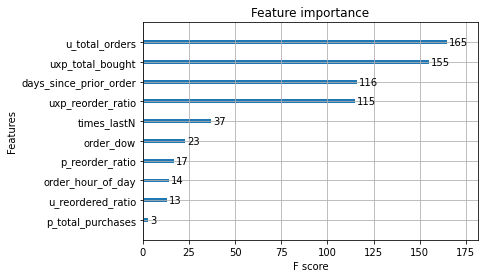

In [ ]:
feat_cols = ['uxp_total_bought', 'uxp_reorder_ratio', 'times_lastN', 'u_total_orders', 'u_reordered_ratio', 'p_total_purchases',
             'p_reorder_ratio', 'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'label']

X_train, y_train = new_data_train[feat_cols[:-1]], new_data_train[feat_cols[-1]]

parameters = best_params

xgbc = xgb.XGBClassifier(objective='binary:logistic', parameters=parameters, num_boost_round=10, n_jobs=-1, silent=False)

model_xgb = xgbc.fit(X_train, y_train)

xgb.plot_importance(model_xgb)

precision_xgb = {}
recall_xgb = {}
for i in range(1, 11):
  precision_xgb[i] = 0
  recall_xgb[i] = 0

total = 0

for user_id, group_u in tqdm(new_val_set.groupby('user_id'), position=0):

  for order_id, group_o in group_u.groupby('order_id'):
    #Купленные товары
    bought = np.array(list(set(group_o['product_id'])))

    #Ищем товары, которые порекомендует бустинг
    order = group_o[['order_id', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']]
    prods = new_data_train[new_data_train['user_id']==user_id].drop_duplicates(subset=['product_id'])

    prods['order_dow'] = prods['order_dow'].apply(lambda x: order['order_dow'].values[0])
    prods['order_hour_of_day'] = prods['order_hour_of_day'].apply(lambda x: order['order_hour_of_day'].values[0])
    prods['days_since_prior_order'] = prods['days_since_prior_order'].apply(lambda x: order['days_since_prior_order'].values[0])

    prods['prob'] =  model_xgb.predict_proba(prods[feat_cols[:-1]])[:, 1]

    for i in range(1, 11):
      recommended_xgb = np.array(list(map(lambda x:int(x[0]),sorted(prods[['product_id', 'prob']].values, key=lambda x: x[1], reverse=True)[:i])))
      precision_xgb[i] += np.intersect1d(bought, recommended_xgb).shape[0]/recommended_xgb.shape[0]
      recall_xgb[i] += np.intersect1d(bought, recommended_xgb).shape[0]/bought.shape[0]

    total += 1

for i in range(1, 11):
  precision_xgb[i] = precision_xgb[i]/total
  recall_xgb[i] = recall_xgb[i]/total

print('\n')
print(precision_xgb)
print(recall_xgb)

###Проверяем качество на тесте

С признаками w2v

In [ ]:
feat_cols = ['uxp_total_bought', 'uxp_reorder_ratio', 'times_lastN', 'u_total_orders', 'u_reordered_ratio', 'p_total_purchases',
             'p_reorder_ratio', 'order_dow', 'order_hour_of_day', 'days_since_prior_order',
             '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', 'label']

X_train, y_train = new_data_train[feat_cols[:-1]], new_data_train[feat_cols[-1]]

parameters = best_params

xgbc = xgb.XGBClassifier(objective='binary:logistic', parameters=parameters, num_boost_round=10, n_jobs=-1, silent=False)

model_xgb = xgbc.fit(X_train, y_train)

xgb.plot_importance(model_xgb)


precision_xgb = {}
recall_xgb = {}
for i in range(1, 11):
  precision_xgb[i] = 0
  recall_xgb[i] = 0

total = 0

for user_id, group_u in tqdm(new_test_set.groupby('user_id'), position=0):

  for order_id, group_o in group_u.groupby('order_id'):
    #Купленные товары
    bought = np.array(list(set(group_o['product_id'])))

    #Ищем товары, которые порекомендует бустинг
    order = group_o[['order_id', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']]
    prods = new_data_train[new_data_train['user_id']==user_id].drop_duplicates(subset=['product_id'])

    prods['order_dow'] = prods['order_dow'].apply(lambda x: order['order_dow'].values[0])
    prods['order_hour_of_day'] = prods['order_hour_of_day'].apply(lambda x: order['order_hour_of_day'].values[0])
    prods['days_since_prior_order'] = prods['days_since_prior_order'].apply(lambda x: order['days_since_prior_order'].values[0])

    prods['prob'] =  model_xgb.predict_proba(prods[feat_cols[:-1]])[:, 1]

    for i in range(1, 11):
      recommended_xgb = np.array(list(map(lambda x:int(x[0]),sorted(prods[['product_id', 'prob']].values, key=lambda x: x[1], reverse=True)[:i])))
      precision_xgb[i] += np.intersect1d(bought, recommended_xgb).shape[0]/recommended_xgb.shape[0]
      recall_xgb[i] += np.intersect1d(bought, recommended_xgb).shape[0]/bought.shape[0]

    total += 1

for i in range(1, 11):
  precision_xgb[i] = precision_xgb[i]/total
  recall_xgb[i] = recall_xgb[i]/total

print('\n')
print(precision_xgb)
print(recall_xgb)

metric_with_w2v_feats = {}

metric_with_w2v_feats[it] = [precision_xgb, recall_xgb]

with open('/content/drive/My Drive/Colab Notebooks/Diplom/models/word_to_vec/metric_with_w2v_feats.pkl', 'wb') as f:
  pkl.dump(metric_with_w2v_feats, f)

 90%|█████████ | 5966/6605 [03:57<00:25, 25.49it/s]

Без признаков w2v

In [ ]:
feat_cols = ['uxp_total_bought', 'uxp_reorder_ratio', 'times_lastN', 'u_total_orders', 'u_reordered_ratio', 'p_total_purchases',
             'p_reorder_ratio', 'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'label']

X_train, y_train = new_data_train[feat_cols[:-1]], new_data_train[feat_cols[-1]]

parameters = best_params

xgbc = xgb.XGBClassifier(objective='binary:logistic', parameters=parameters, num_boost_round=10, n_jobs=-1, silent=False)

model_xgb = xgbc.fit(X_train, y_train)

xgb.plot_importance(model_xgb)

precision_xgb = {}
recall_xgb = {}
for i in range(1, 11):
  precision_xgb[i] = 0
  recall_xgb[i] = 0

total = 0

for user_id, group_u in tqdm(new_test_set.groupby('user_id'), position=0):

  for order_id, group_o in group_u.groupby('order_id'):
    #Купленные товары
    bought = np.array(list(set(group_o['product_id'])))

    #Ищем товары, которые порекомендует бустинг
    order = group_o[['order_id', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']]
    prods = new_data_train[new_data_train['user_id']==user_id].drop_duplicates(subset=['product_id'])

    prods['order_dow'] = prods['order_dow'].apply(lambda x: order['order_dow'].values[0])
    prods['order_hour_of_day'] = prods['order_hour_of_day'].apply(lambda x: order['order_hour_of_day'].values[0])
    prods['days_since_prior_order'] = prods['days_since_prior_order'].apply(lambda x: order['days_since_prior_order'].values[0])

    prods['prob'] =  model_xgb.predict_proba(prods[feat_cols[:-1]])[:, 1]

    for i in range(1, 11):
      recommended_xgb = np.array(list(map(lambda x:int(x[0]),sorted(prods[['product_id', 'prob']].values, key=lambda x: x[1], reverse=True)[:i])))
      precision_xgb[i] += np.intersect1d(bought, recommended_xgb).shape[0]/recommended_xgb.shape[0]
      recall_xgb[i] += np.intersect1d(bought, recommended_xgb).shape[0]/bought.shape[0]

    total += 1

for i in range(1, 11):
  precision_xgb[i] = precision_xgb[i]/total
  recall_xgb[i] = recall_xgb[i]/total

print('\n')
print(precision_xgb)
print(recall_xgb)

metric_without_w2v_feats = {}

metric_without_w2v_feats[it] = [precision_xgb, recall_xgb]

with open('/content/drive/My Drive/Colab Notebooks/Diplom/models/word_to_vec/metric_without_w2v_feats.pkl', 'wb') as f:
  pkl.dump(metric_without_w2v_feats, f)

100%|██████████| 1278/1278 [00:27<00:00, 46.38it/s]



{1: 0.6137841352405722, 2: 0.5211313394018205, 3: 0.48862158647594545, 4: 0.4763220632856531, 5: 0.46907238838318405, 6: 0.46493281317728646, 7: 0.46327636386154003, 8: 0.46196436311845973, 9: 0.4612328936776259, 10: 0.4608138790843612}
{1: 0.5697876029475513, 2: 0.7573905504984828, 3: 0.8425877763328998, 4: 0.9000758560901606, 5: 0.9324447334200261, 6: 0.9487754659731253, 7: 0.9638383181621154, 8: 0.9713697442566104, 9: 0.9749458170784568, 10: 0.9790637191157345}
